In [1]:
using QuantumOptics
using PyPlot
using LaTeXStrings
using Random
using DelimitedFiles
using NPZ, Printf
using LinearAlgebra
using DifferentialEquations
using SpecialFunctions
using SparseArrays
using StatsBase
using Optim

In [2]:
function mb(op,bases,idx)

    numHilberts = size(bases,1)

    if idx==1
        mbop = op
    else
        mbop = identityoperator(bases[1])
    end

    for i=2:numHilberts

        if i==idx
            mbop = tensor(mbop,op)
        else
            mbop = tensor(mbop,identityoperator(bases[i]))
        end

    end

    return mbop
end

mb (generic function with 1 method)

In [3]:
seed = Int(round(mod(time()*300,1000)))

559

In [4]:
fockmax = 10
Nspin = 20
fb = FockBasis(fockmax)
sb = SpinBasis(Nspin//2)
bases = [sb, fb]
a = mb(destroy(fb), bases, 2)
Sx = mb(sigmax(sb), bases, 1)
Sy = mb(sigmay(sb), bases, 1)
Sz = mb(sigmaz(sb), bases, 1)

function single_run(seed, λrel, κ = 2π*0.15, Δc = 2π*20, ωz = 2π*0.01)# ALL IN MHz
    # κ = 2π*0.15 # MHz
    # Δc = 2π*20 # MHz
    # ωz = 2π*0.01 # MHz
    λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 
    λ = λrel*λc
    free_energy(α) = Δc*(α[1]^2) - Nspin*sqrt((ωz^2)/4 + (α[1]^2)*(4*λ^2)/Nspin)
    result = optimize(free_energy, ones(1), BFGS())
    αinit = -2.0*Optim.minimizer(result)[1]
    φinit = atan(2*λ*abs(αinit)/sqrt(Nspin), ωz/2)

    dt=0.0001
    recordtimes = 5000
    tspan = range(0., 100.0/(2*κ), recordtimes)

    C = sqrt(2*κ)*a
    H0 = Δc*dagger(a)*a + ωz*Sz + 2*λ*(dagger(a) + a)*Sx/sqrt(Nspin)

    ψ0 = tensor(spindown(sb), coherentstate(fb,αinit))# + coherentstate(b,-0.7))
    ψ0 = exp(im*φinit/2*Sy)*ψ0
    ψ0 = normalize!(ψ0);
    @assert abs(expect(mb(projector(basisstate(fb, 11)), bases, 2), ψ0)) < 0.01
    print("Running with seed: ", seed)
    Hs = C
    Y = dagger(C)
    CdagC = -0.5im*dagger(C)*C
    H_nl(ψ) = im*expect(Y, normalize(ψ))*Hs + CdagC

    fdet_homodyne(t, ψ) = H0 + H_nl(ψ)
    fst_homodyne(t, ψ) = [Hs]

    W = WienerProcess(0.,im*0., im*0.)

    tout, psi_t = stochastic.schroedinger_dynamic(tspan, ψ0, fdet_homodyne, fst_homodyne; dt=dt, normalize_state=true, noise=W, seed=seed, alg=SOSRI2(), reltol=10^-4, abstol=10^-4, maxiters=10^8);
    return tout, psi_t, W
end

single_run (generic function with 4 methods)

In [5]:
tout, psi_t, W = single_run(seed, 1.2);

Running with seed: 559

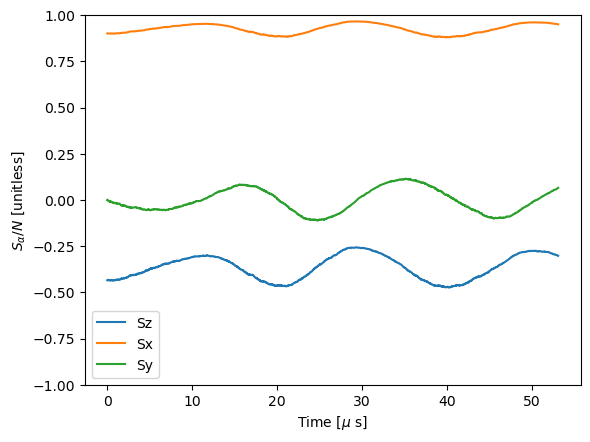

C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [6]:
plot(tout, expect(Sz/Nspin, psi_t), label="Sz")
plot(tout, expect(Sx/Nspin, psi_t), label="Sx")
plot(tout, expect(Sy/Nspin, psi_t), label="Sy")

# plot(tout, expect((Sx^2 + Sy^2 + Sz^2)/(Nspin*(Nspin-1)), psi_t))
PyPlot.legend()
PyPlot.ylim(-1.,1.)
PyPlot.ylabel("\$S_{\\alpha}/N\$ [unitless]")
PyPlot.xlabel("Time [\$\\mu\$ s]")
PyPlot.display_figs()

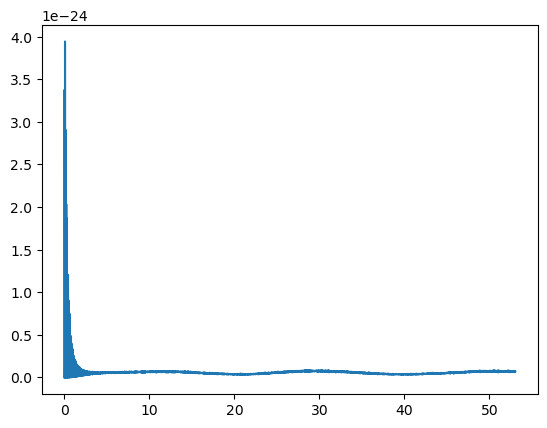

In [7]:
# plot(tout, real(expect(mb(projector(basisstate(fb, 1)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 2)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 3)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 4)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 5)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 6)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 7)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 8)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 9)), bases, 2), psi_t)))
# plot(tout, real(expect(mb(projector(basisstate(fb, 10)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 11)), bases, 2), psi_t)))
PyPlot.display_figs()

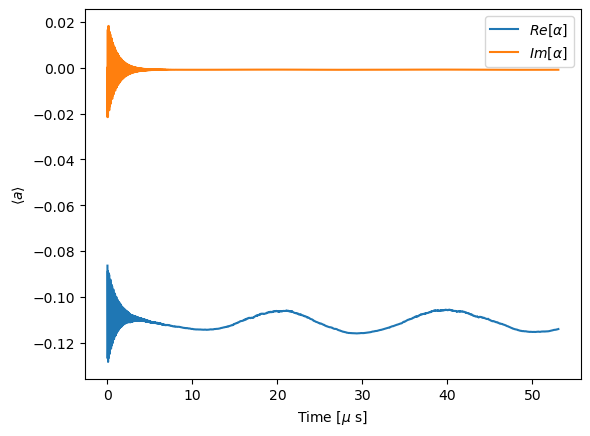

In [8]:
alpha = expect(a, psi_t)
# alphafilt = filter(alpha, 50000*dt, dt)
plot(tout, real(alpha), label=L"$Re[\alpha]$")
plot(tout, imag(alpha), label=L"$Im[\alpha]$")
# plot(tout, abs.(alpha), label=L"|\alpha|")
xlabel("Time [\$\\mu\$ s]")
ylabel(L"$\langle a \rangle$")
PyPlot.legend()
PyPlot.display_figs()

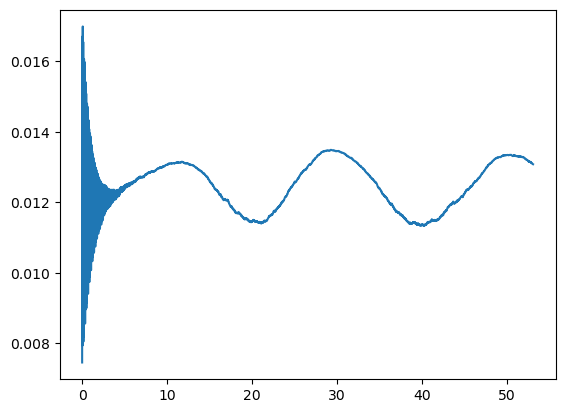

In [9]:
plot(tout, expect(dagger(a)*a, psi_t))
PyPlot.display_figs()

In [10]:
function window(signal::Union{Vector{Float64},Vector{ComplexF64}}, time::Vector{Float64}, dt::Float64)::Vector{Float64}
    Ntime = length(time)
    Ttotal = time[Ntime] - time[1]
    Nfilt = Int64(ceil(Ttotal/dt))
    filtered = im*zeros(Nfilt)
    time_indx = 1
    for i=1:Nfilt
        window_size = 0
        while time_indx <= Ntime && time[time_indx] < dt*(i+1)
            # print(time_indx, " ", Ntime,"\n")
            window_size += 1
            # print(length(filtered), " ", Nfilt, "\n")
            filtered[i] += signal[time_indx]
            time_indx += 1
        end
        filtered[i] /= window_size
    end
    return filtered
end

function filter(signal, time_scale, dt)
    N = length(signal)
    filtered = zeros(typeof(signal[1]), N)
    for i=2:N
        filtered[i] = filtered[i-1]*exp(-dt/time_scale) + signal[i]*(dt/time_scale)
        # filtered[i] = filtered[i-1]*0.9 + 0.2*homodyne_[i]
    end
    return filtered 
end

function two_point_correlator(signal::Union{Vector{Float64},Vector{ComplexF64}}, time::Vector{Float64}, dt::Float64, time_steps::Int;prefilter::Union{Nothing, Float64}=nothing, delay_start::Union{Nothing, Integer}=nothing)::Vector{Float64}
    if delay_start != nothing
        signal = signal[delay_start:length(signal)]
        time = time[delay_start:length(time)]
    end
    signal = window(signal, time, dt)
    N = length(signal)
    if prefilter != nothing
        signal = filter(signal, prefilter, dt)
        N = N-1
    end
    rslt = zeros(time_steps)
    avg = sum(signal[1:N])/N
    for i = 1:time_steps
        rslt[i] = sum(signal[1:N-i] .* signal[i+1:N])/(N-i) - (avg)^2
    end
    return rslt
end

two_point_correlator (generic function with 1 method)

In [15]:
white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

In [16]:
white_noise

5000-element Vector{ComplexF64}:
                  0.0 + 0.0im
  -11.610206920064536 + 7.394589731471161im
   -9.388053250988234 - 3.213083846144985im
   11.796614159871703 + 1.2634248012265406im
   0.2849702930711789 + 6.364022260393702im
   17.017419141323703 + 4.190452927682525im
   -6.830474746723742 - 1.5341463115833631im
  -3.0247635026098743 - 1.610856785893904im
 -0.09380204359726046 + 8.262782155987276im
    6.070546655554054 + 0.9205363973134414im
                      ⋮
   -1.175395890650426 + 6.121772218331105im
  -11.327179684253473 + 0.494406543013593im
   0.2436757659321576 + 0.3315769674340147im
  -0.7076539054908587 - 4.541612007281535im
    7.078068059273036 + 7.2120642044110745im
    3.034203962212738 - 2.1519031737138024im
   -0.793693067612933 - 6.997406850428753im
   -3.943461630377498 - 0.40653703346439046im
   -2.372616106572564 - 1.112831954927631im

In [18]:
Jhet = sqrt(2*2π*0.15)*expect(a, psi_t) + conj(white_noise);

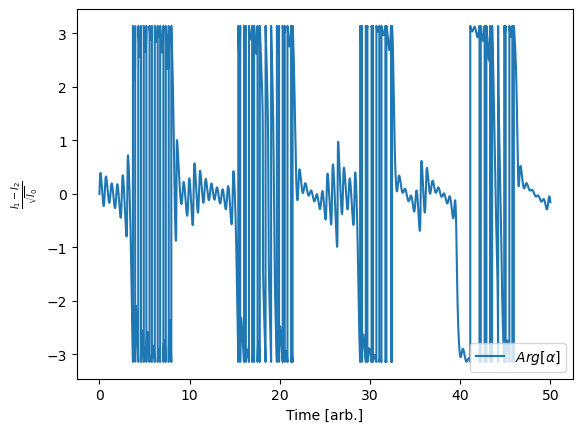

In [81]:
alpha = expect(a, psi_t)
# alphafilt = filter(alpha, 50000*dt, dt)
plot(tout, angle.(-alpha), label=L"$Arg[\alpha]$")
xlabel("Time [arb.]")
ylabel(L"$\frac{I_1-I_2}{\sqrt{I_0}}$")
PyPlot.legend()
PyPlot.display_figs()

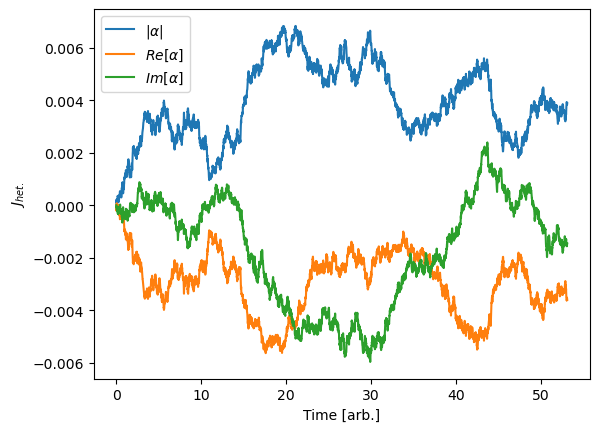

In [32]:
dt = tout[2] - tout[1]
Jhetfilt = filter(Jhet, 100000*dt, dt)
plot(tout, abs.(Jhetfilt), label=L"|\alpha|")
plot(tout, real(Jhetfilt), label=L"Re[\alpha]")
plot(tout, imag(Jhetfilt), label=L"Im[\alpha]")
xlabel("Time [arb.]")
ylabel(L"$J_{het.}$")
PyPlot.legend()
PyPlot.display_figs()

In [56]:
plot(1000*dt*collect(1:100), two_point_correlator(Jhom, tout, 1000*dt, 100))
xlabel(L"\tau [arb.]")
ylabel(L"$G(\tau)$")
PyPlot.display_figs()

InexactError: InexactError: Float64(-2.0906407451856044 - 5.311867192882194im)